In [287]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from gtda.pipeline import Pipeline
from gtda.time_series import Resampler
from gtda.diagrams import PersistenceEntropy, Scaler, HeatKernel, BettiCurve
import numpy as np
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters, TakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer

We start by analyzing the public data set and looking at the normal operations time series, to set a benchmark for the analysis of well events (abnormal operations). 

In [369]:
sample_data_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/WELL-00005_20170402180043.csv")

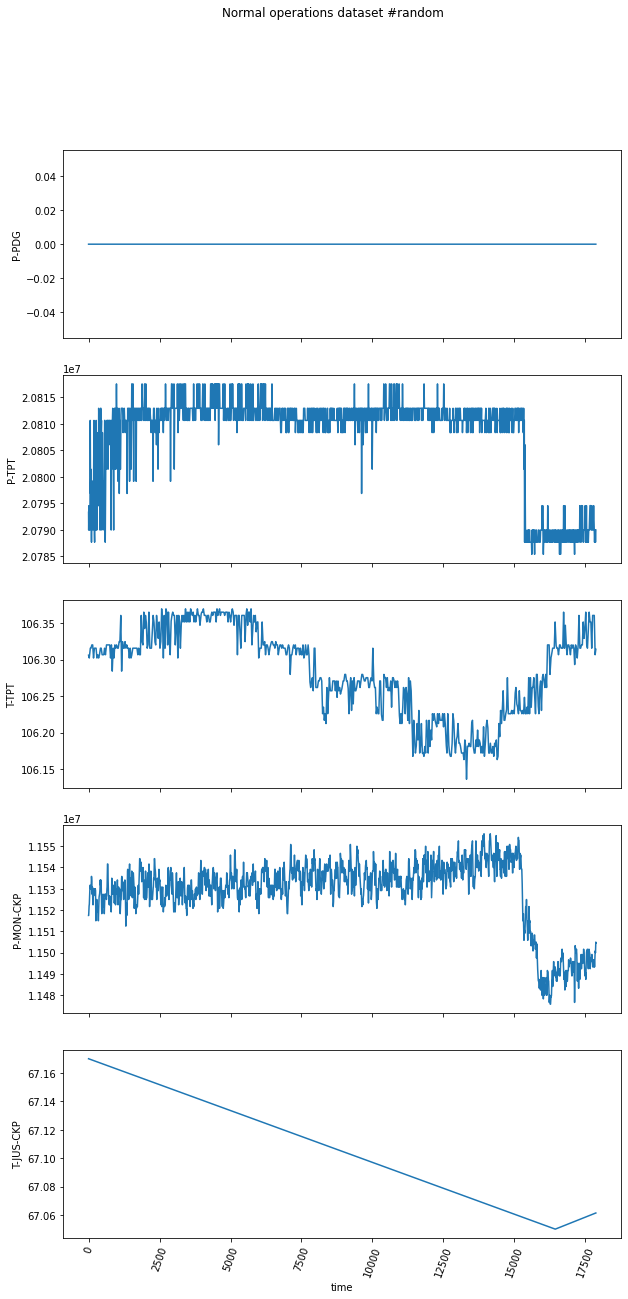

In [373]:
fig, ts = plt.subplots(5,figsize=(10,20),sharex = True)

fig.suptitle('Normal operations dataset #random')
ts[4].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(sample_data_df.index, sample_data_df["P-PDG"])
ts[1].plot(sample_data_df.index, sample_data_df["P-TPT"])
ts[2].plot(sample_data_df.index, sample_data_df["T-TPT"])
ts[3].plot(sample_data_df.index, sample_data_df["P-MON-CKP"])
ts[4].plot(sample_data_df.index, sample_data_df["T-JUS-CKP"])

## Analysis of Normal Operations: P- TPT

In [269]:
def find_shortest_file(path, label):
    tmp = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        tmp.append(len(data_df[label]))
    return min(tmp)

In [270]:
def read_files(path, label, limit):
    data = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        # fill NaN with an interpolated value
        data_df = data_df.interpolate()
        period = int(len(data_df)/limit)
        periodicSampler = Resampler(period=period)
        # print(file, len(data_df), limit, 'resampled to period:', period)
        # resample the files to that all of them are the same length (in entries)
        # NOTE: timestamps are omitted and timesteps are going to be different for each resampled time series!
        index_sampled, signal_sampled = periodicSampler.fit_transform_resample(data_df.index, data_df[label])
        data.append(signal_sampled)
    data_T = list(map(list, zip(*data)))
    df = pd.DataFrame.from_records(data_T)
    return data, df

In [271]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0", "P-TPT")

7010

In [272]:
normal_signals, normal_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/", "P-TPT",7000)

In [273]:
normal_df

0           1          2           3          4           5    \
0     8698015.0  13987430.0  8648771.0  13036680.0  8055306.0  14184150.0   
1     8698015.0  13987410.0  8648666.0  13036670.0  8054974.0  14184150.0   
2     8698015.0  13987390.0  8648560.0  13036660.0  8054641.0  14184150.0   
3     8698015.0  13987370.0  8648456.0  13036650.0  8054308.0  14184150.0   
4     8698015.0  13987350.0  8648351.0  13036650.0  8053976.0  14184150.0   
...         ...         ...        ...         ...        ...         ...   
7005  8420715.0  13986730.0  8578317.0  12998830.0  8717964.0  14224980.0   
7006  8420383.0  13986600.0  8578317.0  12999160.0  8717964.0  14224840.0   
7007  8420050.0  13986480.0  8578317.0  12999490.0  8717964.0  14224710.0   
7008  8419717.0  13986350.0  8578317.0  12999830.0  8717964.0  14224580.0   
7009  8419386.0  13986220.0  8578317.0  13000160.0  8717964.0  14224440.0   

             6           7           8           9    ...        587  \
0     14221150.0  20932460.0  13385940.0  21146550.0  ...  8706865.0   
1     14221370.0  20931700.0  13386030.0  21146550.0  ...  8706792.0   
2     14221590.0  20930930.0  13386130.0  21146550.0  ...  8706720.0   
3     14221820.0  20930170.0  13386220.0  21146550.0  ...  8706647.0   
4     14222040.0  20929400.0  13386310.0  21146550.0  ...  8706575.0   
...          ...         ...         ...         ...  ...        ...   
7005  14184150.0  20911490.0  13385700.0  21146550.0  ...  8478569.0   
7006  14184150.0  20911210.0  13385520.0  21146550.0  ...  8478569.0   
7007  14184150.0  20910920.0  13385330.0  21146550.0  ...  8478569.0   
7008  14184150.0  20910630.0  13385140.0  21146550.0  ...  8478569.0   
7009  14184150.0  20910340.0  13384950.0  21146550.0  ...  8478569.0   

            588         589         590         591         592         593  \
0     8550073.0  13849550.0  20997960.0  20811280.0  10005130.0  20934760.0   
1     8550283.0  13849630.0  20998250.0  20810870.0  10005340.0  20931310.0   
2     8550493.0  13849720.0  20998540.0  20810660.0  10005550.0  20927870.0   
3     8550703.0  13849800.0  20998830.0  20810660.0  10005760.0  20930170.0   
4     8550913.0  13849890.0  20999110.0  20810660.0  10005970.0  20932460.0   
...         ...         ...         ...         ...         ...         ...   
7005  8578317.0  13846380.0  20995550.0  20812950.0  10014690.0  20883690.0   
7006  8578317.0  13846280.0  20995440.0  20812950.0  10014690.0  20883430.0   
7007  8578317.0  13846180.0  20995320.0  20812950.0  10014690.0  20883180.0   
7008  8578317.0  13846070.0  20995210.0  20812950.0  10014690.0  20882920.0   
7009  8578317.0  13845970.0  20995090.0  20813370.0  10014690.0  20882670.0   

            594        595        596  
0     8179326.0  8499783.0  8101855.0  
1     8179326.0  8499915.0  8101190.0  
2     8179326.0  8500049.0  8100525.0  
3     8179326.0  8500182.0  8099860.0  
4     8179326.0  8500314.0  8099195.0  
...         ...        ...        ...  
7005  7929529.0  8498519.0  8887589.0  
7006  7929433.0  8498519.0  8887482.0  
7007  7929339.0  8498519.0  8887373.0  
7008  7929243.0  8498519.0  8887266.0  
7009  7929149.0  8498519.0  8887158.0  

[7010 rows x 597 columns]

In [274]:
signal = normal_df[6]
max_time_delay = 200
max_embedding_dimension = 30
stride = 3

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay


embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 200
Optimal embedding dimension based on false nearest neighbors: 10


Let's start by using one single value of embedding parameters for all the regular operation conditions time series. And see if there is any high-dimensional homology generator (dim=2).

In [280]:
def batch_analyzer(input_df, stride, max_embedding_dimension, max_time_delay):
    max_time_delay = int(max_time_delay)
    max_embedding_dimension = int(max_embedding_dimension)
    homology_dimensions = (0, 1)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
    pca = PCA(n_components=3)
    PE_signal = PersistenceEntropy()
    PE_norm = PersistenceEntropy(normalize=True)

    entropies = []
    norm_entropies = []
    diagrams = []
    point_clouds_pca = []
    i = 0

    for timeserie in input_df:
        i += 1
        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
            input_df[timeserie], max_time_delay, max_embedding_dimension, stride=stride
            )
        if optimal_embedding_dimension < 3:
            optimal_embedding_dimension = 3
            
        print('analyzing nr.',i, 'progress:',int(100*i/len(input_df.columns)),'%', 'dim',optimal_embedding_dimension,'delay', optimal_time_delay)

        embedder = SingleTakensEmbedding(
            parameters_type="fixed", n_jobs=6, time_delay=optimal_time_delay, dimension=optimal_embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(input_df[timeserie])
        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        X_diagram = VRP.fit_transform(y_signal_embedded_reshaped)
        features = PE_signal.fit_transform(X_diagram)
        features_norm = PE_norm.fit_transform(X_diagram)

        point_clouds_pca.append(y_signal_embedded_pca)
        entropies.append(features)
        norm_entropies.append(features_norm)
        diagrams.append(X_diagram)
    return(point_clouds_pca, diagrams, entropies, norm_entropies)

In [279]:
normal_point_clouds_pca, normal_diagrams, normal_entropies, normal_norm_entropies = batch_analyzer(normal_df, 5, 25, 90)

analyzing nr. 1 progress: 0 % dim 6 delay 87
analyzing nr. 2 progress: 0 % dim 8 delay 71
analyzing nr. 3 progress: 0 % dim 14 delay 90
analyzing nr. 4 progress: 0 % dim 9 delay 90
analyzing nr. 5 progress: 0 % dim 5 delay 90
analyzing nr. 6 progress: 1 % dim 14 delay 90
analyzing nr. 7 progress: 1 % dim 11 delay 87
analyzing nr. 8 progress: 1 % dim 10 delay 73
analyzing nr. 9 progress: 1 % dim 6 delay 69
analyzing nr. 10 progress: 1 % dim 3 delay 90
analyzing nr. 11 progress: 1 % dim 11 delay 90
analyzing nr. 12 progress: 2 % dim 15 delay 78
analyzing nr. 13 progress: 2 % dim 7 delay 61
analyzing nr. 14 progress: 2 % dim 11 delay 86
analyzing nr. 15 progress: 2 % dim 5 delay 90
analyzing nr. 16 progress: 2 % dim 7 delay 85
analyzing nr. 17 progress: 2 % dim 5 delay 90
analyzing nr. 18 progress: 3 % dim 8 delay 80
analyzing nr. 19 progress: 3 % dim 7 delay 89
analyzing nr. 20 progress: 3 % dim 13 delay 89
analyzing nr. 21 progress: 3 % dim 11 delay 90
analyzing nr. 22 progress: 3 % dim

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 51 progress: 8 % dim 7 delay 90
analyzing nr. 52 progress: 8 % dim 11 delay 87
analyzing nr. 53 progress: 8 % dim 14 delay 85
analyzing nr. 54 progress: 9 % dim 9 delay 83
analyzing nr. 55 progress: 9 % dim 5 delay 90
analyzing nr. 56 progress: 9 % dim 14 delay 88
analyzing nr. 57 progress: 9 % dim 4 delay 85
analyzing nr. 58 progress: 9 % dim 8 delay 89
analyzing nr. 59 progress: 9 % dim 3 delay 89
analyzing nr. 60 progress: 10 % dim 8 delay 87
analyzing nr. 61 progress: 10 % dim 7 delay 89
analyzing nr. 62 progress: 10 % dim 12 delay 89
analyzing nr. 63 progress: 10 % dim 8 delay 51
analyzing nr. 64 progress: 10 % dim 10 delay 88
analyzing nr. 65 progress: 10 % dim 6 delay 66
analyzing nr. 66 progress: 11 % dim 11 delay 22
analyzing nr. 67 progress: 11 % dim 6 delay 90
analyzing nr. 68 progress: 11 % dim 14 delay 89
analyzing nr. 69 progress: 11 % dim 5 delay 87
analyzing nr. 70 progress: 11 % dim 6 delay 85
analyzing nr. 71 progress: 11 % dim 10 delay 90
analyzing nr. 

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 77 progress: 12 % dim 3 delay 89
analyzing nr. 78 progress: 13 % dim 9 delay 88
analyzing nr. 79 progress: 13 % dim 3 delay 89
analyzing nr. 80 progress: 13 % dim 11 delay 90
analyzing nr. 81 progress: 13 % dim 10 delay 90
analyzing nr. 82 progress: 13 % dim 6 delay 84
analyzing nr. 83 progress: 13 % dim 12 delay 90
analyzing nr. 84 progress: 14 % dim 8 delay 87
analyzing nr. 85 progress: 14 % dim 14 delay 90
analyzing nr. 86 progress: 14 % dim 11 delay 90
analyzing nr. 87 progress: 14 % dim 14 delay 90
analyzing nr. 88 progress: 14 % dim 13 delay 87
analyzing nr. 89 progress: 14 % dim 7 delay 90
analyzing nr. 90 progress: 15 % dim 12 delay 88
analyzing nr. 91 progress: 15 % dim 11 delay 87
analyzing nr. 92 progress: 15 % dim 11 delay 87
analyzing nr. 93 progress: 15 % dim 11 delay 86
analyzing nr. 94 progress: 15 % dim 14 delay 86
analyzing nr. 95 progress: 15 % dim 6 delay 63
analyzing nr. 96 progress: 16 % dim 6 delay 66
analyzing nr. 97 progress: 16 % dim 12 delay 89


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 107 progress: 17 % dim 11 delay 21
analyzing nr. 108 progress: 18 % dim 6 delay 81
analyzing nr. 109 progress: 18 % dim 14 delay 90
analyzing nr. 110 progress: 18 % dim 9 delay 88
analyzing nr. 111 progress: 18 % dim 10 delay 43
analyzing nr. 112 progress: 18 % dim 14 delay 85
analyzing nr. 113 progress: 18 % dim 9 delay 83
analyzing nr. 114 progress: 19 % dim 7 delay 89
analyzing nr. 115 progress: 19 % dim 5 delay 82
analyzing nr. 116 progress: 19 % dim 9 delay 89
analyzing nr. 117 progress: 19 % dim 11 delay 69
analyzing nr. 118 progress: 19 % dim 13 delay 90
analyzing nr. 119 progress: 19 % dim 10 delay 89
analyzing nr. 120 progress: 20 % dim 7 delay 87
analyzing nr. 121 progress: 20 % dim 7 delay 90
analyzing nr. 122 progress: 20 % dim 14 delay 89
analyzing nr. 123 progress: 20 % dim 3 delay 1


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 124 progress: 20 % dim 11 delay 87
analyzing nr. 125 progress: 20 % dim 5 delay 90
analyzing nr. 126 progress: 21 % dim 11 delay 90
analyzing nr. 127 progress: 21 % dim 3 delay 90
analyzing nr. 128 progress: 21 % dim 5 delay 90
analyzing nr. 129 progress: 21 % dim 7 delay 81
analyzing nr. 130 progress: 21 % dim 11 delay 90
analyzing nr. 131 progress: 21 % dim 9 delay 86
analyzing nr. 132 progress: 22 % dim 10 delay 80
analyzing nr. 133 progress: 22 % dim 6 delay 89
analyzing nr. 134 progress: 22 % dim 8 delay 90
analyzing nr. 135 progress: 22 % dim 3 delay 87
analyzing nr. 136 progress: 22 % dim 14 delay 90
analyzing nr. 137 progress: 22 % dim 3 delay 90
analyzing nr. 138 progress: 23 % dim 14 delay 90
analyzing nr. 139 progress: 23 % dim 3 delay 1


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 140 progress: 23 % dim 12 delay 90
analyzing nr. 141 progress: 23 % dim 10 delay 85
analyzing nr. 142 progress: 23 % dim 11 delay 63
analyzing nr. 143 progress: 23 % dim 13 delay 89
analyzing nr. 144 progress: 24 % dim 3 delay 90
analyzing nr. 145 progress: 24 % dim 6 delay 86
analyzing nr. 146 progress: 24 % dim 14 delay 90
analyzing nr. 147 progress: 24 % dim 7 delay 67
analyzing nr. 148 progress: 24 % dim 10 delay 89
analyzing nr. 149 progress: 24 % dim 11 delay 23
analyzing nr. 150 progress: 25 % dim 8 delay 87
analyzing nr. 151 progress: 25 % dim 9 delay 83
analyzing nr. 152 progress: 25 % dim 13 delay 88
analyzing nr. 153 progress: 25 % dim 4 delay 83
analyzing nr. 154 progress: 25 % dim 11 delay 37
analyzing nr. 155 progress: 25 % dim 14 delay 90
analyzing nr. 156 progress: 26 % dim 6 delay 89
analyzing nr. 157 progress: 26 % dim 5 delay 79
analyzing nr. 158 progress: 26 % dim 6 delay 73
analyzing nr. 159 progress: 26 % dim 3 delay 88
analyzing nr. 160 progress: 26

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 164 progress: 27 % dim 8 delay 58
analyzing nr. 165 progress: 27 % dim 7 delay 56
analyzing nr. 166 progress: 27 % dim 15 delay 57
analyzing nr. 167 progress: 27 % dim 8 delay 89
analyzing nr. 168 progress: 28 % dim 8 delay 60
analyzing nr. 169 progress: 28 % dim 10 delay 90
analyzing nr. 170 progress: 28 % dim 16 delay 34
analyzing nr. 171 progress: 28 % dim 14 delay 88
analyzing nr. 172 progress: 28 % dim 17 delay 66
analyzing nr. 173 progress: 28 % dim 14 delay 88
analyzing nr. 174 progress: 29 % dim 14 delay 89
analyzing nr. 175 progress: 29 % dim 6 delay 86
analyzing nr. 176 progress: 29 % dim 8 delay 89
analyzing nr. 177 progress: 29 % dim 11 delay 87
analyzing nr. 178 progress: 29 % dim 17 delay 72
analyzing nr. 179 progress: 29 % dim 3 delay 1


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 180 progress: 30 % dim 12 delay 89
analyzing nr. 181 progress: 30 % dim 5 delay 89
analyzing nr. 182 progress: 30 % dim 9 delay 62
analyzing nr. 183 progress: 30 % dim 13 delay 89
analyzing nr. 184 progress: 30 % dim 7 delay 50
analyzing nr. 185 progress: 30 % dim 8 delay 81
analyzing nr. 186 progress: 31 % dim 11 delay 53
analyzing nr. 187 progress: 31 % dim 8 delay 89
analyzing nr. 188 progress: 31 % dim 5 delay 90
analyzing nr. 189 progress: 31 % dim 13 delay 89
analyzing nr. 190 progress: 31 % dim 11 delay 52
analyzing nr. 191 progress: 31 % dim 14 delay 88
analyzing nr. 192 progress: 32 % dim 8 delay 90
analyzing nr. 193 progress: 32 % dim 9 delay 79
analyzing nr. 194 progress: 32 % dim 12 delay 90
analyzing nr. 195 progress: 32 % dim 6 delay 84
analyzing nr. 196 progress: 32 % dim 9 delay 38
analyzing nr. 197 progress: 32 % dim 6 delay 16
analyzing nr. 198 progress: 33 % dim 11 delay 89
analyzing nr. 199 progress: 33 % dim 9 delay 89
analyzing nr. 200 progress: 33 %

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 222 progress: 37 % dim 8 delay 79
analyzing nr. 223 progress: 37 % dim 14 delay 90
analyzing nr. 224 progress: 37 % dim 3 delay 89
analyzing nr. 225 progress: 37 % dim 5 delay 90
analyzing nr. 226 progress: 37 % dim 10 delay 90
analyzing nr. 227 progress: 38 % dim 5 delay 90
analyzing nr. 228 progress: 38 % dim 7 delay 86
analyzing nr. 229 progress: 38 % dim 7 delay 72
analyzing nr. 230 progress: 38 % dim 10 delay 88
analyzing nr. 231 progress: 38 % dim 10 delay 89
analyzing nr. 232 progress: 38 % dim 8 delay 78
analyzing nr. 233 progress: 39 % dim 7 delay 89
analyzing nr. 234 progress: 39 % dim 8 delay 90
analyzing nr. 235 progress: 39 % dim 7 delay 39
analyzing nr. 236 progress: 39 % dim 16 delay 72
analyzing nr. 237 progress: 39 % dim 3 delay 90
analyzing nr. 238 progress: 39 % dim 8 delay 60
analyzing nr. 239 progress: 40 % dim 9 delay 88
analyzing nr. 240 progress: 40 % dim 10 delay 86
analyzing nr. 241 progress: 40 % dim 8 delay 89
analyzing nr. 242 progress: 40 % d

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 248 progress: 41 % dim 5 delay 85
analyzing nr. 249 progress: 41 % dim 14 delay 86
analyzing nr. 250 progress: 41 % dim 8 delay 90
analyzing nr. 251 progress: 42 % dim 9 delay 88
analyzing nr. 252 progress: 42 % dim 3 delay 89
analyzing nr. 253 progress: 42 % dim 9 delay 88
analyzing nr. 254 progress: 42 % dim 11 delay 90
analyzing nr. 255 progress: 42 % dim 14 delay 90
analyzing nr. 256 progress: 42 % dim 9 delay 89
analyzing nr. 257 progress: 43 % dim 5 delay 90
analyzing nr. 258 progress: 43 % dim 9 delay 89
analyzing nr. 259 progress: 43 % dim 7 delay 88
analyzing nr. 260 progress: 43 % dim 3 delay 89
analyzing nr. 261 progress: 43 % dim 14 delay 90
analyzing nr. 262 progress: 43 % dim 14 delay 87
analyzing nr. 263 progress: 44 % dim 12 delay 89
analyzing nr. 264 progress: 44 % dim 3 delay 90
analyzing nr. 265 progress: 44 % dim 3 delay 90
analyzing nr. 266 progress: 44 % dim 8 delay 89
analyzing nr. 267 progress: 44 % dim 11 delay 87
analyzing nr. 268 progress: 44 % 

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 278 progress: 46 % dim 13 delay 90
analyzing nr. 279 progress: 46 % dim 8 delay 87
analyzing nr. 280 progress: 46 % dim 12 delay 89
analyzing nr. 281 progress: 47 % dim 7 delay 85
analyzing nr. 282 progress: 47 % dim 12 delay 89
analyzing nr. 283 progress: 47 % dim 6 delay 78
analyzing nr. 284 progress: 47 % dim 12 delay 78
analyzing nr. 285 progress: 47 % dim 6 delay 82
analyzing nr. 286 progress: 47 % dim 14 delay 88
analyzing nr. 287 progress: 48 % dim 9 delay 89
analyzing nr. 288 progress: 48 % dim 8 delay 84
analyzing nr. 289 progress: 48 % dim 3 delay 1


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 290 progress: 48 % dim 6 delay 51
analyzing nr. 291 progress: 48 % dim 9 delay 51
analyzing nr. 292 progress: 48 % dim 7 delay 84
analyzing nr. 293 progress: 49 % dim 9 delay 85
analyzing nr. 294 progress: 49 % dim 15 delay 82
analyzing nr. 295 progress: 49 % dim 7 delay 86
analyzing nr. 296 progress: 49 % dim 6 delay 30
analyzing nr. 297 progress: 49 % dim 13 delay 87
analyzing nr. 298 progress: 49 % dim 5 delay 90
analyzing nr. 299 progress: 50 % dim 11 delay 85
analyzing nr. 300 progress: 50 % dim 14 delay 89
analyzing nr. 301 progress: 50 % dim 13 delay 87
analyzing nr. 302 progress: 50 % dim 13 delay 90
analyzing nr. 303 progress: 50 % dim 8 delay 86
analyzing nr. 304 progress: 50 % dim 14 delay 90
analyzing nr. 305 progress: 51 % dim 14 delay 90
analyzing nr. 306 progress: 51 % dim 5 delay 90
analyzing nr. 307 progress: 51 % dim 10 delay 89
analyzing nr. 308 progress: 51 % dim 9 delay 39
analyzing nr. 309 progress: 51 % dim 11 delay 90
analyzing nr. 310 progress: 51

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 346 progress: 57 % dim 14 delay 85
analyzing nr. 347 progress: 58 % dim 16 delay 70
analyzing nr. 348 progress: 58 % dim 9 delay 60
analyzing nr. 349 progress: 58 % dim 14 delay 89
analyzing nr. 350 progress: 58 % dim 8 delay 55
analyzing nr. 351 progress: 58 % dim 7 delay 56
analyzing nr. 352 progress: 58 % dim 9 delay 88
analyzing nr. 353 progress: 59 % dim 10 delay 90
analyzing nr. 354 progress: 59 % dim 13 delay 90
analyzing nr. 355 progress: 59 % dim 3 delay 89
analyzing nr. 356 progress: 59 % dim 6 delay 66
analyzing nr. 357 progress: 59 % dim 12 delay 87
analyzing nr. 358 progress: 59 % dim 8 delay 69
analyzing nr. 359 progress: 60 % dim 6 delay 87
analyzing nr. 360 progress: 60 % dim 6 delay 89
analyzing nr. 361 progress: 60 % dim 5 delay 90
analyzing nr. 362 progress: 60 % dim 11 delay 89
analyzing nr. 363 progress: 60 % dim 5 delay 90
analyzing nr. 364 progress: 60 % dim 5 delay 90
analyzing nr. 365 progress: 61 % dim 13 delay 90
analyzing nr. 366 progress: 61 %

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 392 progress: 65 % dim 6 delay 87
analyzing nr. 393 progress: 65 % dim 5 delay 90
analyzing nr. 394 progress: 65 % dim 13 delay 73
analyzing nr. 395 progress: 66 % dim 5 delay 90
analyzing nr. 396 progress: 66 % dim 3 delay 1


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 397 progress: 66 % dim 13 delay 89
analyzing nr. 398 progress: 66 % dim 11 delay 89
analyzing nr. 399 progress: 66 % dim 5 delay 90
analyzing nr. 400 progress: 67 % dim 9 delay 87
analyzing nr. 401 progress: 67 % dim 14 delay 85
analyzing nr. 402 progress: 67 % dim 6 delay 88
analyzing nr. 403 progress: 67 % dim 11 delay 87
analyzing nr. 404 progress: 67 % dim 6 delay 90
analyzing nr. 405 progress: 67 % dim 14 delay 84
analyzing nr. 406 progress: 68 % dim 13 delay 85
analyzing nr. 407 progress: 68 % dim 5 delay 72
analyzing nr. 408 progress: 68 % dim 14 delay 87
analyzing nr. 409 progress: 68 % dim 9 delay 89
analyzing nr. 410 progress: 68 % dim 7 delay 86
analyzing nr. 411 progress: 68 % dim 12 delay 89
analyzing nr. 412 progress: 69 % dim 7 delay 89
analyzing nr. 413 progress: 69 % dim 9 delay 88
analyzing nr. 414 progress: 69 % dim 9 delay 56
analyzing nr. 415 progress: 69 % dim 5 delay 85
analyzing nr. 416 progress: 69 % dim 9 delay 88
analyzing nr. 417 progress: 69 %

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 464 progress: 77 % dim 13 delay 89
analyzing nr. 465 progress: 77 % dim 13 delay 69
analyzing nr. 466 progress: 78 % dim 8 delay 81
analyzing nr. 467 progress: 78 % dim 9 delay 89
analyzing nr. 468 progress: 78 % dim 11 delay 72
analyzing nr. 469 progress: 78 % dim 14 delay 89
analyzing nr. 470 progress: 78 % dim 12 delay 90
analyzing nr. 471 progress: 78 % dim 13 delay 89
analyzing nr. 472 progress: 79 % dim 13 delay 89
analyzing nr. 473 progress: 79 % dim 11 delay 89
analyzing nr. 474 progress: 79 % dim 8 delay 89
analyzing nr. 475 progress: 79 % dim 7 delay 65
analyzing nr. 476 progress: 79 % dim 7 delay 30
analyzing nr. 477 progress: 79 % dim 7 delay 57
analyzing nr. 478 progress: 80 % dim 14 delay 89
analyzing nr. 479 progress: 80 % dim 5 delay 90
analyzing nr. 480 progress: 80 % dim 7 delay 89
analyzing nr. 481 progress: 80 % dim 8 delay 75
analyzing nr. 482 progress: 80 % dim 7 delay 89
analyzing nr. 483 progress: 80 % dim 3 delay 90
analyzing nr. 484 progress: 81 

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide



analyzing nr. 516 progress: 86 % dim 9 delay 90
analyzing nr. 517 progress: 86 % dim 14 delay 90
analyzing nr. 518 progress: 86 % dim 7 delay 89
analyzing nr. 519 progress: 86 % dim 5 delay 90
analyzing nr. 520 progress: 87 % dim 6 delay 71
analyzing nr. 521 progress: 87 % dim 10 delay 90
analyzing nr. 522 progress: 87 % dim 12 delay 89
analyzing nr. 523 progress: 87 % dim 14 delay 87
analyzing nr. 524 progress: 87 % dim 3 delay 88
analyzing nr. 525 progress: 87 % dim 14 delay 90
analyzing nr. 526 progress: 88 % dim 7 delay 86
analyzing nr. 527 progress: 88 % dim 15 delay 78
analyzing nr. 528 progress: 88 % dim 8 delay 89
analyzing nr. 529 progress: 88 % dim 11 delay 87
analyzing nr. 530 progress: 88 % dim 13 delay 87
analyzing nr. 531 progress: 88 % dim 14 delay 89
analyzing nr. 532 progress: 89 % dim 7 delay 89
analyzing nr. 533 progress: 89 % dim 14 delay 88
analyzing nr. 534 progress: 89 % dim 9 delay 83
analyzing nr. 535 progress: 89 % dim 3 delay 90
analyzing nr. 536 progress: 89

In [348]:
tmp = normal_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H1_series = pd.Series(Entropy_H1)

In [356]:
tmp = normal_norm_entropies
Entropy_H0_norm = []
Entropy_H1_norm = []

for item in tmp:
    Entropy_H0_norm.append(item[0][0])
    Entropy_H1_norm.append(item[0][1])

Entropy_H1_norm_series = pd.Series(Entropy_H1_norm)

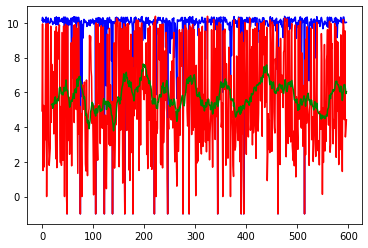

In [357]:
plt.plot(Entropy_H0, 'b-')
plt.plot(Entropy_H1, 'r-')
plt.plot(Entropy_H1_series.rolling(20).mean(), 'g-')

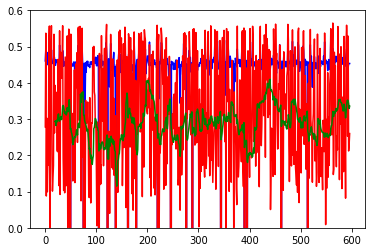

In [361]:
plt.plot(Entropy_H0_norm, 'b-')
plt.plot(Entropy_H1_norm, 'r-')
plt.ylim([0,0.6])
plt.plot(Entropy_H1_norm_series.rolling(20).mean(), 'g-')

So, entropies (non-normalized) are clustered around 10 for H0 generators, and 6 for H1 generators with the latter having a much larger variance. 

Looking more carefully at the timeseries, we can see that those that give the most problems are those who are monotonically increasing or decreasing. 

In [283]:
i = 0
for timeserie in normal_df:
    i += 1
   # print(normal_df[timeserie].iloc[-1])
    if abs(normal_df[timeserie].iloc[-1]-normal_df[timeserie].iloc[0]) > 1000000:
        print(i-1, normal_df[timeserie].iloc[-1], normal_df[timeserie].iloc[0])

41 8737914.0 7644843.0
441 9099334.0 7947331.0
446 9087492.0 7461141.0


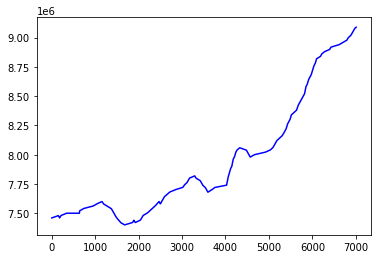

In [284]:
plt.plot(normal_df[446], 'b-')

In [293]:
plot_point_cloud(normal_point_clouds_pca[446])

In [294]:
persistence.plot(normal_diagrams[446])

In [295]:
print('Entropy for timeseries #446:', Entropy_H0[446], Entropy_H1[446])

Entropy for timeseries #446: 10.079591610761957 2.5306232701975513


These have some high persistency H1 points, probably due to some dynamics that is not evident at this scale. Other low-entropy time series have some sort of dynamic, and we argue that they may not be entirely classified correctly as normal operations.

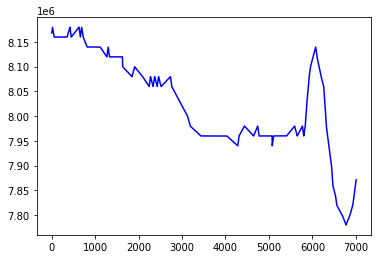

In [296]:
plt.plot(normal_df[114], 'b-')

In [299]:
persistence.plot(normal_diagrams[114])

In [300]:
plot_point_cloud(normal_point_clouds_pca[114])

In [301]:
print('Entropy for timeseries #114:', Entropy_H0[114], Entropy_H1[114])

Entropy for timeseries #114: 9.8792310412809 3.052116133676827


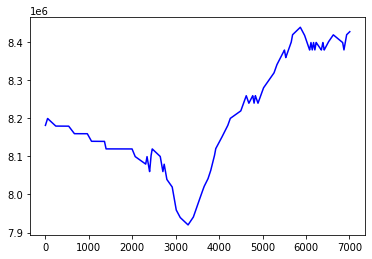

In [302]:
plt.plot(normal_df[491], 'b-')

In [303]:
plot_point_cloud(normal_point_clouds_pca[491])

In [304]:
persistence.plot(normal_diagrams[491])

In [305]:
print('Entropy for timeseries #25:', Entropy_H0[491], Entropy_H1[491])

Entropy for timeseries #25: 10.09771953819825 2.4404847974603814


Other stationary time series show instead no high persistence points and more high entropy (around 10) for both H0 and H1 generators. 

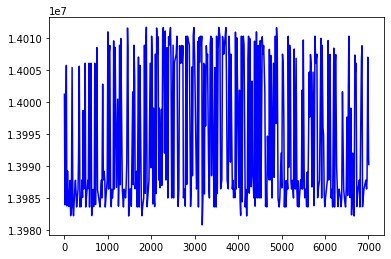

In [306]:
plt.plot(normal_df[25], 'b-')

freq units: 1.426534E-05 Hz


<AxesSubplot:xlabel='BHP', ylabel='count'>

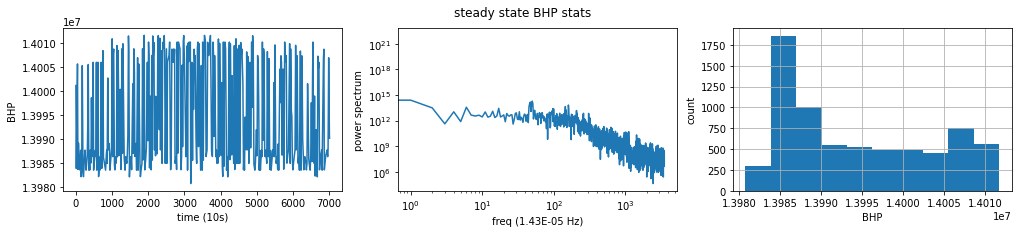

In [334]:
fig_ss_analysis, data = plt.subplots(1, 3, figsize=(17, 3))

from random import gauss
from random import seed
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot

freq_units = 0.1/len(normal_df[25])
print('freq units: %(units)4E Hz' %{"units":(freq_units)})

fig_ss_analysis.suptitle('steady state BHP stats')
data[0].set_xlabel('time (10s)')
data[0].set_ylabel('BHP')
data[1].set_xlabel('freq (%(units).2E Hz)' %{"units":(freq_units)})
data[1].set_ylabel('power spectrum')
data[2].set_xlabel('BHP')
data[2].set_ylabel('count')

#data[1].set_xlim(1,1000)
#data[1].set_ylim(0,1E013)
data[1].set_yscale('log')
data[1].set_xscale('log')

ss_BHP = normal_df[25]

fft_ss = np.fft.rfft(ss_BHP)
fft_ss_abs = np.abs(fft_ss)
power_spectrum_ss = np.square(fft_ss_abs)


data[0].plot(ss_BHP)
data[1].plot(power_spectrum_ss)
ss_BHP.hist()

In [307]:
plot_point_cloud(normal_point_clouds_pca[25])

In [336]:
persistence.plot(normal_diagrams[25])

In [337]:
print('Entropy for timeseries #25:', Entropy_H0[25], Entropy_H1[25])

Entropy for timeseries #25: 10.296608055849124 9.515581674047807


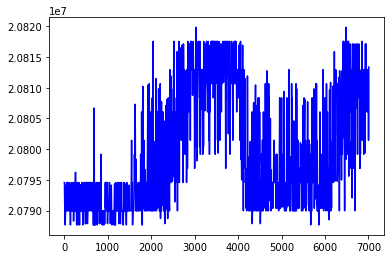

In [338]:
plt.plot(normal_df[189], 'b-')

In [362]:
print('Entropy for timeseries #25:', Entropy_H0[189], Entropy_H1[189])

Entropy for timeseries #25: 10.240582080317116 10.111049656070263


Note that jumps in the mean of the time serie do not affect the persistence diagram nor the entropy of the embedded time series.

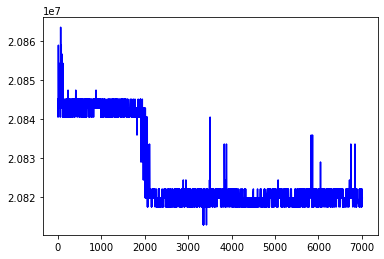

In [363]:
plt.plot(normal_df[188], 'b-')

In [367]:
plot_point_cloud(normal_point_clouds_pca[188])

In [366]:
persistence.plot(normal_diagrams[188])

In [374]:
print('Entropy for timeseries #25:', Entropy_H0[188], Entropy_H1[188])

Entropy for timeseries #25: 10.141485944195972 10.127561771513783


## Analysis of Normal Operations: T- TPT

In [375]:
normal_signals, normal_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/", "T-TPT",7000)

In [376]:
TTPT_normal_point_clouds_pca, TTPT_normal_diagrams, TTPT_normal_entropies, TTPT_normal_norm_entropies = batch_analyzer(normal_df, 5, 25, 90)

analyzing nr. 1 progress: 0 % dim 14 delay 87
analyzing nr. 2 progress: 0 % dim 12 delay 86
analyzing nr. 3 progress: 0 % dim 14 delay 90
analyzing nr. 4 progress: 0 % dim 16 delay 68
analyzing nr. 5 progress: 0 % dim 12 delay 90
analyzing nr. 6 progress: 1 % dim 11 delay 90
analyzing nr. 7 progress: 1 % dim 11 delay 88
analyzing nr. 8 progress: 1 % dim 8 delay 89
analyzing nr. 9 progress: 1 % dim 17 delay 70
analyzing nr. 10 progress: 1 % dim 13 delay 89
analyzing nr. 11 progress: 1 % dim 11 delay 87
analyzing nr. 12 progress: 2 % dim 9 delay 84
analyzing nr. 13 progress: 2 % dim 10 delay 81
analyzing nr. 14 progress: 2 % dim 11 delay 87
analyzing nr. 15 progress: 2 % dim 7 delay 89
analyzing nr. 16 progress: 2 % dim 12 delay 90
analyzing nr. 17 progress: 2 % dim 11 delay 86
analyzing nr. 18 progress: 3 % dim 10 delay 85
analyzing nr. 19 progress: 3 % dim 7 delay 90
analyzing nr. 20 progress: 3 % dim 14 delay 89
analyzing nr. 21 progress: 3 % dim 13 delay 90
analyzing nr. 22 progress:

analyzing nr. 174 progress: 29 % dim 14 delay 43
analyzing nr. 175 progress: 29 % dim 10 delay 58
analyzing nr. 176 progress: 29 % dim 12 delay 79
analyzing nr. 177 progress: 29 % dim 3 delay 89
analyzing nr. 178 progress: 29 % dim 7 delay 56
analyzing nr. 179 progress: 29 % dim 12 delay 89
analyzing nr. 180 progress: 30 % dim 10 delay 86
analyzing nr. 181 progress: 30 % dim 9 delay 90
analyzing nr. 182 progress: 30 % dim 13 delay 87
analyzing nr. 183 progress: 30 % dim 14 delay 71
analyzing nr. 184 progress: 30 % dim 8 delay 89
analyzing nr. 185 progress: 30 % dim 10 delay 83
analyzing nr. 186 progress: 31 % dim 10 delay 75
analyzing nr. 187 progress: 31 % dim 5 delay 89
analyzing nr. 188 progress: 31 % dim 13 delay 82
analyzing nr. 189 progress: 31 % dim 10 delay 83
analyzing nr. 190 progress: 31 % dim 11 delay 87
analyzing nr. 191 progress: 31 % dim 5 delay 90
analyzing nr. 192 progress: 32 % dim 16 delay 43
analyzing nr. 193 progress: 32 % dim 11 delay 87
analyzing nr. 194 progress

analyzing nr. 343 progress: 57 % dim 17 delay 66
analyzing nr. 344 progress: 57 % dim 13 delay 88
analyzing nr. 345 progress: 57 % dim 13 delay 88
analyzing nr. 346 progress: 57 % dim 3 delay 1
analyzing nr. 347 progress: 58 % dim 19 delay 56
analyzing nr. 348 progress: 58 % dim 9 delay 88
analyzing nr. 349 progress: 58 % dim 21 delay 32
analyzing nr. 350 progress: 58 % dim 10 delay 67
analyzing nr. 351 progress: 58 % dim 11 delay 79
analyzing nr. 352 progress: 58 % dim 5 delay 90
analyzing nr. 353 progress: 59 % dim 13 delay 85
analyzing nr. 354 progress: 59 % dim 14 delay 63
analyzing nr. 355 progress: 59 % dim 12 delay 89
analyzing nr. 356 progress: 59 % dim 12 delay 85
analyzing nr. 357 progress: 59 % dim 14 delay 85
analyzing nr. 358 progress: 59 % dim 11 delay 83
analyzing nr. 359 progress: 60 % dim 13 delay 86
analyzing nr. 360 progress: 60 % dim 11 delay 89
analyzing nr. 361 progress: 60 % dim 5 delay 90
analyzing nr. 362 progress: 60 % dim 6 delay 89
analyzing nr. 363 progress

analyzing nr. 512 progress: 85 % dim 7 delay 89
analyzing nr. 513 progress: 85 % dim 3 delay 1
analyzing nr. 514 progress: 86 % dim 14 delay 53
analyzing nr. 515 progress: 86 % dim 5 delay 87
analyzing nr. 516 progress: 86 % dim 8 delay 90
analyzing nr. 517 progress: 86 % dim 14 delay 90
analyzing nr. 518 progress: 86 % dim 10 delay 85
analyzing nr. 519 progress: 86 % dim 7 delay 84
analyzing nr. 520 progress: 87 % dim 9 delay 66
analyzing nr. 521 progress: 87 % dim 10 delay 90
analyzing nr. 522 progress: 87 % dim 14 delay 85
analyzing nr. 523 progress: 87 % dim 11 delay 87
analyzing nr. 524 progress: 87 % dim 14 delay 90
analyzing nr. 525 progress: 87 % dim 7 delay 80
analyzing nr. 526 progress: 88 % dim 11 delay 85
analyzing nr. 527 progress: 88 % dim 14 delay 65
analyzing nr. 528 progress: 88 % dim 13 delay 89
analyzing nr. 529 progress: 88 % dim 14 delay 89
analyzing nr. 530 progress: 88 % dim 11 delay 87
analyzing nr. 531 progress: 88 % dim 9 delay 73
analyzing nr. 532 progress: 8

The reason for a low average of H1-entropies is in the sharp oscillations seen in most of the time series.  

In [ ]:
Entropy_H1[20]

In [ ]:
plt.plot(normal_df[20], 'b-')

In [ ]:
plot_point_cloud(point_clouds_pca[20])

In [341]:
persistence.plot(diagrams[20])

In [561]:
steps = [#("resampler", resampler),
         ("embedder", embedder),
         ("pca", batch_pca),
         #("persistence", persistence),
         #("scaling", scaling),
         #("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [526]:
features_new = topological_transfomer.fit_transform(features.T)
features_new.shape

(2, 950, 3)

In [539]:
plot_point_cloud(features_new[0])

Just checking by comparing with a single embedding 

In [622]:
slug_data_single_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/test/WELL-00001_20170320130025.csv")
signal = slug_data_single_df["P-TPT"]

In [623]:
optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=optimal_embedding_dimension, time_delay=optimal_time_delay, dimension=6, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 289
Optimal embedding dimension based on false nearest neighbors: 9


In [541]:
signal_embedded_pca.shape

(1748, 3)

Here I mention a pathological time series that, even though it represents normal operations, it shows a periodic pattern, i.e. high persistency.

In [3]:
normal_data_df_231 = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/WELL-00004_20140807000129.csv")

In [4]:
target = normal_data_df_231["P-TPT"][0]
for entry in normal_df:
    if normal_df[entry][0] == target:
        print(entry)

NameError: name 'normal_df' is not defined

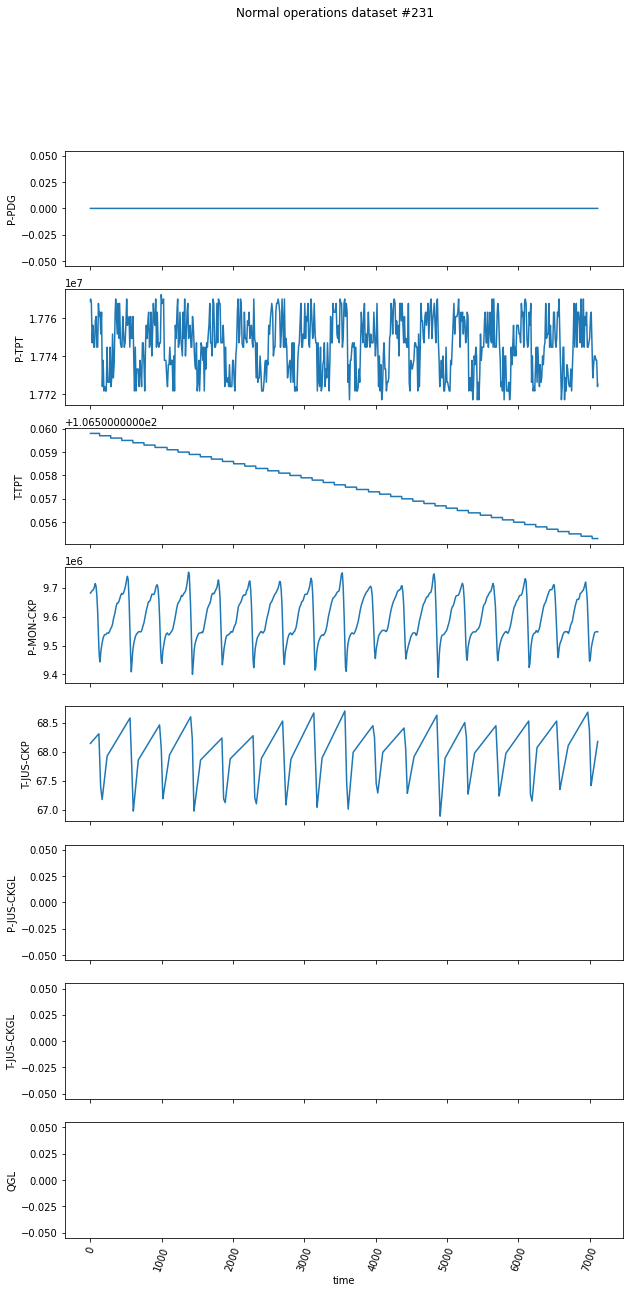

In [5]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Normal operations dataset #231')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(normal_data_df_231.index, normal_data_df_231["P-PDG"])
ts[1].plot(normal_data_df_231.index, normal_data_df_231["P-TPT"])
ts[2].plot(normal_data_df_231.index, normal_data_df_231["T-TPT"])
ts[3].plot(normal_data_df_231.index, normal_data_df_231["P-MON-CKP"])
ts[4].plot(normal_data_df_231.index, normal_data_df_231["T-JUS-CKP"])
ts[5].plot(normal_data_df_231.index, normal_data_df_231["P-JUS-CKGL"])
ts[6].plot(normal_data_df_231.index, normal_data_df_231["T-JUS-CKGL"])
ts[7].plot(normal_data_df_231.index, normal_data_df_231["QGL"])

In [6]:
plt.plot(normal_df[231], 'b-')

NameError: name 'normal_df' is not defined

In [15]:
signal = normal_data_df_231['P-TPT']
max_time_delay = 200
max_embedding_dimension = 30
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay


embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 109
Optimal embedding dimension based on false nearest neighbors: 24


Now, looking at the slugging, i.e. dataset nr.3

In [84]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/REAL/", "P-TPT")

14385

In [105]:
slugging_signals, slugging_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/REAL/", "P-TPT",14000)

In [115]:
slugging_df_resampled = slugging_df[::10]

In [116]:
slugging_df_resampled

0           1           2           3           4           5   \
0      15923800.0  16364360.0  14545720.0  15763660.0  14563290.0  16229530.0   
10     15912720.0  16362380.0  14551830.0  15765690.0  14590570.0  16229360.0   
20     15897370.0  16363950.0  14559050.0  15772310.0  14607750.0  16230600.0   
30     15879760.0  16368300.0  14566830.0  15781490.0  14629470.0  16231210.0   
40     15861750.0  16375980.0  14575700.0  15784650.0  14643980.0  16228860.0   
...           ...         ...         ...         ...         ...         ...   
14340  16265760.0  13607280.0  14059430.0  15558700.0  14354830.0  16163460.0   
14350  16266120.0  13592460.0  14051460.0  15569210.0  14364940.0  16161560.0   
14360  16264380.0  13580850.0  14047220.0  15572580.0  14374490.0  16158970.0   
14370  16263990.0  13570900.0  14040280.0  15578120.0  14380860.0  16158050.0   
14380  16259370.0  13563580.0  14034560.0  15585860.0  14390100.0  16158600.0   

               6           7           8           9   ...          22  \
0      15593270.0  14071870.0  15840130.0  14177770.0  ...  13829370.0   
10     15599700.0  14074970.0  15817510.0  14185840.0  ...  13841950.0   
20     15606990.0  14078060.0  15790800.0  14194490.0  ...  13854790.0   
30     15614680.0  14081150.0  15760420.0  14202520.0  ...  13867990.0   
40     15618130.0  14084250.0  15735790.0  14212070.0  ...  13884100.0   
...           ...         ...         ...         ...  ...         ...   
14340  15391360.0  14401270.0  15365030.0  13588620.0  ...  15665990.0   
14350  15406550.0  14402930.0  15363480.0  13611950.0  ...  15672850.0   
14360  15420500.0  14403100.0  15359660.0  13634530.0  ...  15678320.0   
14370  15431360.0  14402280.0  15359120.0  13661450.0  ...  15685390.0   
14380  15448060.0  14401450.0  15355350.0  13683920.0  ...  15693520.0   

               23          24          25          26          27          28  \
0      15829460.0  16268030.0  14860340.0  14000140.0  15411580.0  14999240.0   
10     15835000.0  16263820.0  14871360.0  14008580.0  15420080.0  15006930.0   
20     15840540.0  16260860.0  14880480.0  14015900.0  15426060.0  15013240.0   
30     15848330.0  16257870.0  14894380.0  14025430.0  15434260.0  15018940.0   
40     15854530.0  16256660.0  14905270.0  14036590.0  15443650.0  15026820.0   
...           ...         ...         ...         ...         ...         ...   
14340  15638120.0  16402500.0  16224380.0  13439200.0  14667760.0  16484210.0   
14350  15647460.0  16402670.0  16224770.0  13444420.0  14676040.0  16495450.0   
14360  15657100.0  16401020.0  16231120.0  13449290.0  14682440.0  16510220.0   
14370  15669040.0  16397440.0  16238270.0  13455250.0  14690510.0  16514860.0   
14380  15676190.0  16392530.0  16247070.0  13459610.0  14697940.0  16520740.0   

               29          30          31  
0      15915160.0  14880540.0  13445530.0  
10     15917620.0  14894200.0  13444910.0  
20     15924210.0  14907540.0  13445100.0  
30     15928050.0  14920190.0  13446280.0  
40     15931730.0  14932350.0  13446260.0  
...           ...         ...         ...  
14340  14190940.0  13338100.0  13821130.0  
14350  14197930.0  13314140.0  13826690.0  
14360  14203830.0  13293230.0  13831050.0  
14370  14210310.0  13264290.0  13835890.0  
14380  14217140.0  13244900.0  13842050.0  

[1439 rows x 32 columns]

In [117]:
len(slugging_df_resampled)

1439

In [135]:
slug_point_clouds_pca, slug_diagrams, slug_entropies, slug_norm_entropies = batch_analyzer(slugging_df_resampled, 1, 15, 80)

analyzing nr. 1 progress: 3 % dim 10 delay 80
analyzing nr. 2 progress: 6 % dim 12 delay 66
analyzing nr. 3 progress: 9 % dim 12 delay 65
analyzing nr. 4 progress: 12 % dim 10 delay 78
analyzing nr. 5 progress: 15 % dim 11 delay 73
analyzing nr. 6 progress: 18 % dim 10 delay 80
analyzing nr. 7 progress: 21 % dim 10 delay 78
analyzing nr. 8 progress: 25 % dim 10 delay 76
analyzing nr. 9 progress: 28 % dim 10 delay 77
analyzing nr. 10 progress: 31 % dim 10 delay 78
analyzing nr. 11 progress: 34 % dim 10 delay 80
analyzing nr. 12 progress: 37 % dim 9 delay 78
analyzing nr. 13 progress: 40 % dim 10 delay 79
analyzing nr. 14 progress: 43 % dim 12 delay 63
analyzing nr. 15 progress: 46 % dim 10 delay 79
analyzing nr. 16 progress: 50 % dim 10 delay 76
analyzing nr. 17 progress: 53 % dim 10 delay 80
analyzing nr. 18 progress: 56 % dim 10 delay 76
analyzing nr. 19 progress: 59 % dim 10 delay 79
analyzing nr. 20 progress: 62 % dim 10 delay 78
analyzing nr. 21 progress: 65 % dim 12 delay 67
analy

In [136]:
tmp = slug_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

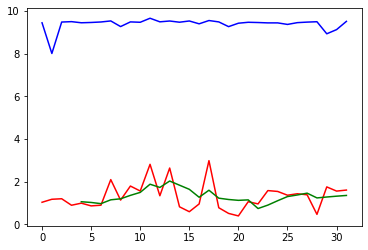

In [137]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [138]:
tmp = slug_norm_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

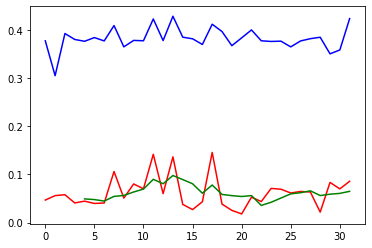

In [139]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [140]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED/", "P-TPT")

12999

In [141]:
slugging_signals, slugging_SIM_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED/", "P-TPT",12500)

In [142]:
slugging_SIM_df_resampled = slugging_SIM_df[::12]

In [143]:
slugging_SIM_df_resampled

0           1           2           3           4           5   \
0       9617383.0  10829880.0  17474200.0  17754000.0  10530620.0  16755150.0   
12      9758343.0  10846340.0  17440000.0  17808320.0  10548300.0  16776490.0   
24      9896418.0  10861680.0  17416940.0  17859440.0  10564300.0  16794920.0   
36     10025620.0  10876030.0  17400240.0  17908190.0  10579210.0  16812100.0   
48     10153210.0  10888400.0  17391410.0  17953440.0  10594060.0  16827020.0   
...           ...         ...         ...         ...         ...         ...   
12948  11216040.0  10897610.0  18159090.0  18100740.0   8654673.0  16642080.0   
12960  11314950.0  10897620.0  18192000.0  18111030.0   8711365.0  16653520.0   
12972  11412780.0  10896680.0  18206220.0  18121550.0   8767361.0  16653410.0   
12984  11506360.0  10894890.0  18217900.0  18129480.0   8822312.0  16662100.0   
12996  11597920.0  10892300.0  18216780.0  18140300.0   8878049.0  16661450.0   

              6           7           8           9   ...          64  \
0      8811328.0  13441160.0  12409290.0  11394700.0  ...  18066200.0   
12     8523611.0  13232290.0  12505160.0  11406760.0  ...  18102440.0   
24     8326209.0  12799260.0  12600190.0  11417490.0  ...  18136790.0   
36     8235298.0  12248710.0  12698990.0  11427370.0  ...  18168480.0   
48     8244808.0  11670690.0  12800430.0  11437400.0  ...  18197630.0   
...          ...         ...         ...         ...  ...         ...   
12948  7990496.0  13457190.0  12277650.0  11619310.0  ...  17918820.0   
12960  8169541.0  13409600.0  12422400.0  11652940.0  ...  17932630.0   
12972  8336687.0  13328330.0  12556430.0  11669990.0  ...  17945350.0   
12984  8485294.0  13161130.0  12679070.0  11696050.0  ...  17960270.0   
12996  8615621.0  12772900.0  12790380.0  11717720.0  ...  17971120.0   

               65          66          67          68          69          70  \
0      18569200.0  12632460.0  17728770.0  11303220.0  19999190.0  16807680.0   
12     18589000.0  12542210.0  17743630.0  11029680.0  19979670.0  16795980.0   
24     18603520.0  12535430.0  17757480.0  10237430.0  19957060.0  16778450.0   
36     18615060.0  12599050.0  17770130.0   9398171.0  19933850.0  16748910.0   
48     18626860.0  12712960.0  17779400.0   8550246.0  19907030.0  16686310.0   
...           ...         ...         ...         ...         ...         ...   
12948  19164120.0  18914040.0  18557270.0  11427900.0  19768390.0  13051310.0   
12960  19185900.0  18831350.0  18550000.0  11427600.0  19767930.0  13054790.0   
12972  19206700.0  18770360.0  18541490.0  11425720.0  19765900.0  13067100.0   
12984  19230440.0  18726820.0  18532890.0  11424330.0  19763110.0  13073230.0   
12996  19254470.0  18697080.0  18524920.0  11424990.0  19759870.0  13065750.0   

               71          72          73  
0      17861390.0  20117520.0  15373900.0  
12     17815940.0  20163660.0  15376100.0  
24     17782180.0  20206340.0  15375160.0  
36     17757760.0  20245700.0  15371000.0  
48     17740970.0  20282150.0  15363540.0  
...           ...         ...         ...  
12948  17773780.0  20286930.0  15306320.0  
12960  17874970.0  20303620.0  15328430.0  
12972  17963370.0  20322600.0  15348050.0  
12984  18039420.0  20351740.0  15364960.0  
12996  18105940.0  20384770.0  15378990.0  

[1084 rows x 74 columns]

In [144]:
slugSIM_point_clouds_pca, slugSIM_diagrams, slugSIM_entropies, slugSIM_norm_entropies = batch_analyzer(slugging_SIM_df_resampled, 1, 15, 50)

analyzing nr. 1 progress: 1 % dim 9 delay 47
analyzing nr. 2 progress: 2 % dim 12 delay 50
analyzing nr. 3 progress: 4 % dim 11 delay 50
analyzing nr. 4 progress: 5 % dim 12 delay 49
analyzing nr. 5 progress: 6 % dim 13 delay 47
analyzing nr. 6 progress: 8 % dim 11 delay 50
analyzing nr. 7 progress: 9 % dim 12 delay 48
analyzing nr. 8 progress: 10 % dim 12 delay 49
analyzing nr. 9 progress: 12 % dim 11 delay 50
analyzing nr. 10 progress: 13 % dim 11 delay 42
analyzing nr. 11 progress: 14 % dim 15 delay 36
analyzing nr. 12 progress: 16 % dim 15 delay 33
analyzing nr. 13 progress: 17 % dim 8 delay 27
analyzing nr. 14 progress: 18 % dim 11 delay 39
analyzing nr. 15 progress: 20 % dim 11 delay 50
analyzing nr. 16 progress: 21 % dim 11 delay 50
analyzing nr. 17 progress: 22 % dim 11 delay 50
analyzing nr. 18 progress: 24 % dim 5 delay 34
analyzing nr. 19 progress: 25 % dim 9 delay 34
analyzing nr. 20 progress: 27 % dim 12 delay 50
analyzing nr. 21 progress: 28 % dim 9 delay 31
analyzing nr.

In [145]:
tmp = slugSIM_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

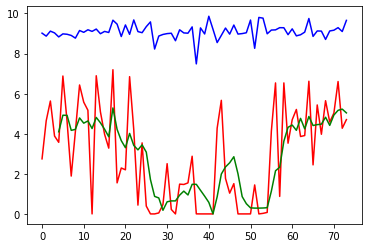

In [146]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [147]:
tmp = slugSIM_norm_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

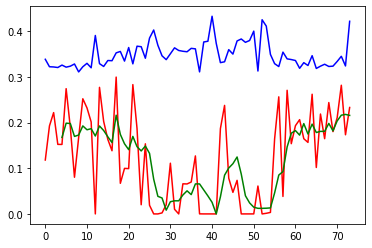

In [148]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [223]:
slug_data_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED_00005.csv")

In [224]:
slug_data_df

timestamp       P-PDG       P-TPT     T-TPT  \
0      2018-04-08 03:23:38.000000  26201590.0  16807680.0  118.3466   
1      2018-04-08 03:23:39.000000  26201410.0  16807450.0  118.3465   
2      2018-04-08 03:23:40.000000  26201220.0  16807220.0  118.3464   
3      2018-04-08 03:23:41.000000  26201030.0  16806980.0  118.3462   
4      2018-04-08 03:23:42.000000  26200840.0  16806750.0  118.3461   
...                           ...         ...         ...       ...   
61994  2018-04-08 20:36:52.000000  26910280.0  17541780.0  112.9325   
61995  2018-04-08 20:36:53.000000  26910300.0  17541870.0  112.9322   
61996  2018-04-08 20:36:54.000000  26910310.0  17541950.0  112.9320   
61997  2018-04-08 20:36:55.000000  26910330.0  17542030.0  112.9317   
61998  2018-04-08 20:36:56.000000  26910350.0  17542110.0  112.9314   

       P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0      4047800.0   83.66679         NaN         NaN  NaN      3  
1      4047815.0   83.66234         NaN         NaN  NaN      3  
2      4047830.0   83.65790         NaN         NaN  NaN      3  
3      4047843.0   83.65346         NaN         NaN  NaN      3  
4      4047856.0   83.64903         NaN         NaN  NaN      3  
...          ...        ...         ...         ...  ...    ...  
61994  4051613.0   49.87471         NaN         NaN  NaN      3  
61995  4051594.0   49.87138         NaN         NaN  NaN      3  
61996  4051575.0   49.86807         NaN         NaN  NaN      3  
61997  4051555.0   49.86476         NaN         NaN  NaN      3  
61998  4051536.0   49.86146         NaN         NaN  NaN      3  

[61999 rows x 10 columns]

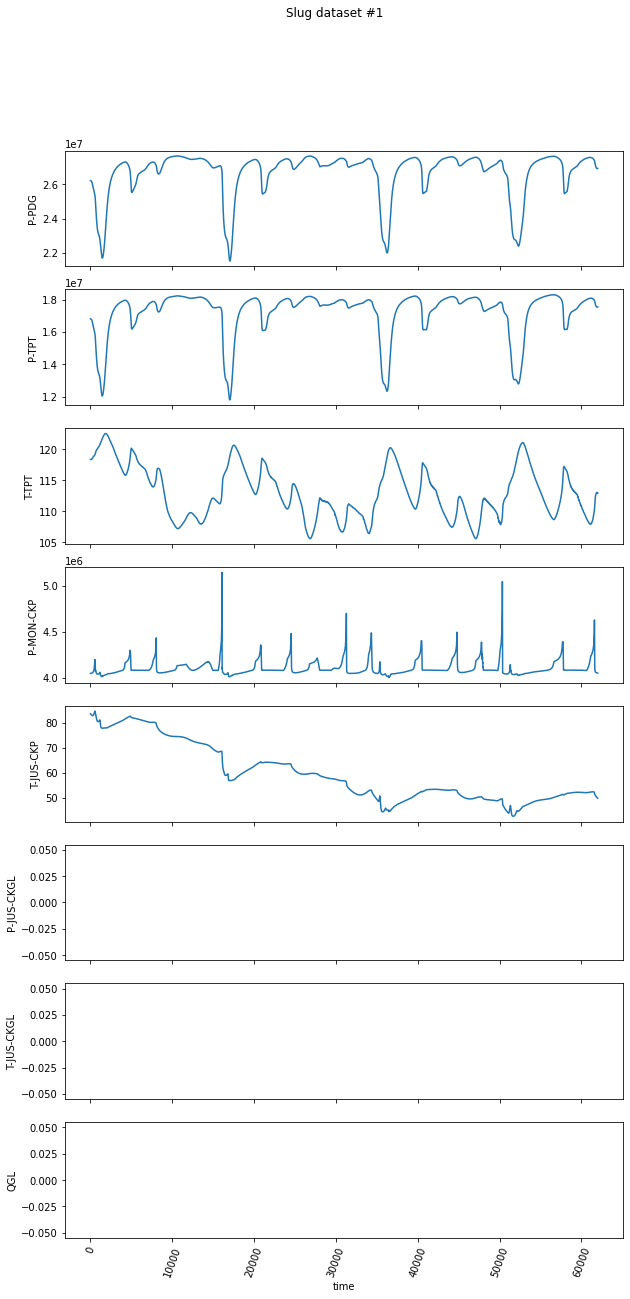

In [225]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_df.index, slug_data_df["P-PDG"])
ts[1].plot(slug_data_df.index, slug_data_df["P-TPT"])
ts[2].plot(slug_data_df.index, slug_data_df["T-TPT"])
ts[3].plot(slug_data_df.index, slug_data_df["P-MON-CKP"])
ts[4].plot(slug_data_df.index, slug_data_df["T-JUS-CKP"])
ts[5].plot(slug_data_df.index, slug_data_df["P-JUS-CKGL"])
ts[6].plot(slug_data_df.index, slug_data_df["T-JUS-CKGL"])
ts[7].plot(slug_data_df.index, slug_data_df["QGL"])


In [226]:
slug_data_df['P-TPT'].isnull().values.any()

False

In [227]:
slug_data_df= slug_data_df.interpolate()

In [233]:
period = 50
periodicSampler = Resampler(period=period)
slug_data_df = slug_data_df.interpolate(method='linear')
signal = slug_data_df["P-TPT"]

#slug_data_df.index, slug_data_df["P-TPT"]
index_sampled, signal_sampled = periodicSampler.fit_transform_resample(slug_data_df.index, signal)

#print(index_sampled, signal_sampled, len(signal_sampled))

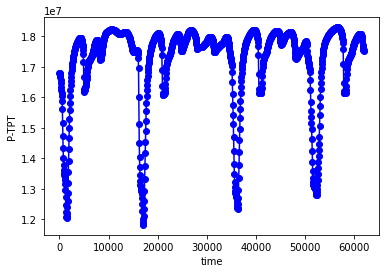

In [234]:
signal_downsampled = pd.DataFrame(signal_sampled,
                  index=index_sampled, columns=['P-TPT'])
#signal_downsampled['P-TPT']
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_downsampled.index,signal_downsampled['P-TPT'], 'bo-')

In [236]:
print('length of signal to analyze', len(signal_downsampled))

max_time_delay = 150 
max_embedding_dimension = 15
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal_downsampled)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

length of signal to analyze 1240
Optimal embedding time delay based on mutual information: 58
Optimal embedding dimension based on false nearest neighbors: 11


In [237]:
homology_dimensions = (0, 1)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

signal_embedded_reshaped = signal_embedded.reshape(1, *signal_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_embedded.shape)

PerHom_signal = VRP.fit_transform(signal_embedded_reshaped)
VRP.plot(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 660, 11)
y_wn_embedded.shape (660, 11)


In [238]:
PE_slug = PersistenceEntropy()
PE_slug_norm = PersistenceEntropy(normalize=True)
features = PE_slug.fit_transform(PerHom_signal)
features_norm = PE_slug_norm.fit_transform(PerHom_signal)

In [239]:
features

array([[9.14272792, 4.02067644]])

In [240]:
features_norm

array([[0.33100592, 0.1620816 ]])

In [265]:
slug_data_sim_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/8/WELL-00021_20170509013517.csv")

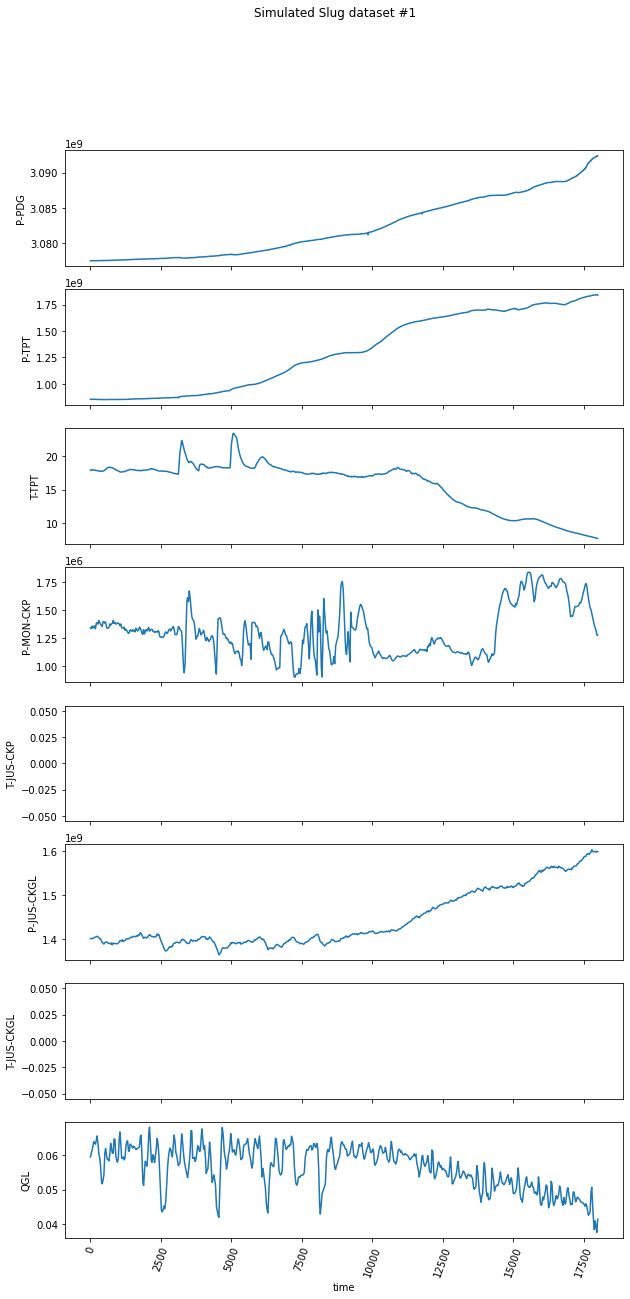

In [266]:
slug_data_sim_df = slug_data_sim_df.head(18000)

fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Simulated Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_sim_df.index, slug_data_sim_df["P-PDG"])
ts[1].plot(slug_data_sim_df.index, slug_data_sim_df["P-TPT"])
ts[2].plot(slug_data_sim_df.index, slug_data_sim_df["T-TPT"])
ts[3].plot(slug_data_sim_df.index, slug_data_sim_df["P-MON-CKP"])
ts[4].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKP"])
ts[5].plot(slug_data_sim_df.index, slug_data_sim_df["P-JUS-CKGL"])
ts[6].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKGL"])
ts[7].plot(slug_data_sim_df.index, slug_data_sim_df["QGL"])


In [253]:
period = 5
periodicSampler = Resampler(period=period)
signal = slug_data_sim_df["P-TPT"]

slug_data_sim_df.index, slug_data_sim_df["P-TPT"]
index_sampled, signal_sim_sampled = periodicSampler.fit_transform_resample(slug_data_sim_df.index, signal)


In [254]:
signal_sim_sampled

array([17747090., 17748130., 17749180., ..., 17782190., 17780100.,
       17776750.])

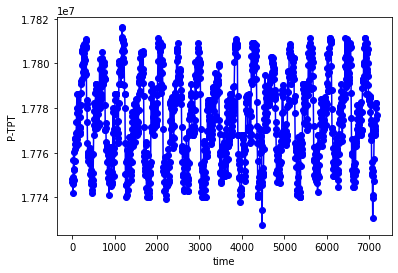

In [255]:
signal_sim_downsampled = pd.DataFrame(signal_sim_sampled,
                  index=index_sampled, columns=['P-TPT'])
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_sim_downsampled.index,signal_sim_downsampled['P-TPT'], 'bo-')

In [256]:
print('length of signal to analyze', len(signal_sim_downsampled))

max_time_delay = 50 
max_embedding_dimension = 10
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_sim_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_sim_embedded = embedder.fit_transform(signal_sim_downsampled)

pca = PCA(n_components=3)
signal_sim_embedded_pca = pca.fit_transform(signal_sim_embedded)

plot_point_cloud(signal_sim_embedded_pca)

length of signal to analyze 1436
Optimal embedding time delay based on mutual information: 16
Optimal embedding dimension based on false nearest neighbors: 9


In [257]:
signal_sim_embedded_reshaped = signal_sim_embedded.reshape(1, *signal_sim_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_sim_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_sim_embedded_reshaped.shape)

PerHom_sim_signal = VRP.fit_transform(signal_sim_embedded_reshaped)
features_sim = PE_slug.fit_transform(PerHom_signal)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 1308, 9)
y_wn_embedded.shape (1, 1308, 9)


In [258]:
features_sim

array([[9.14272792, 4.02067644]])

In [259]:
features_sim_norm

array([[0.33100592, 0.1620816 ]])

In [260]:
VRP.plot(PerHom_sim_signal)

In [82]:
PerHom_sim_signal.shape

(1, 919, 3)

In [89]:
PerHom_signal.shape

#tmp = np.vstack([PerHom_signal,PerHom_sim_signal])
#tmp.shape

(1, 533, 3)

In [94]:
diagramScaler = Scaler()
PerHom_signal_scaled = diagramScaler.fit_transform(PerHom_signal)
diagramScaler.plot(PerHom_signal_scaled)

In [92]:
PerHom_signal_sim_scaled = diagramScaler.fit_transform(PerHom_sim_signal)
diagramScaler.plot(PerHom_signal_sim_scaled)

In [95]:
features_sim = PE_slug.fit_transform(PerHom_signal_scaled)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal_scaled)
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [96]:
features_sim_norm

array([[  1.49319727,   1.05423515, -11.44457834]])

In [111]:
HK = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1) 
HK_slug = HK.fit_transform_plot(PerHom_signal_scaled, homology_dimension_idx=1)

In [112]:
HK.fit_transform_plot(PerHom_signal_sim_scaled, homology_dimension_idx=1)

array([[[[ 5.07638691e+02,  4.99572666e+02,  4.91460183e+02, ...,
           1.66820580e+01,  8.32249323e+00,  0.00000000e+00],
         [ 5.00163881e+02,  4.92070493e+02,  4.83931025e+02, ...,
           8.36008392e+00,  0.00000000e+00, -8.32249323e+00],
         [ 4.92624107e+02,  4.84503736e+02,  4.76337670e+02, ...,
           0.00000000e+00, -8.36008392e+00, -1.66820580e+01],
         ...,
         [ 1.78456729e+01,  8.93264763e+00,  0.00000000e+00, ...,
          -4.76337670e+02, -4.83931025e+02, -4.91460183e+02],
         [ 8.91354577e+00,  0.00000000e+00, -8.93264763e+00, ...,
          -4.84503736e+02, -4.92070493e+02, -4.99572666e+02],
         [ 0.00000000e+00, -8.91354577e+00, -1.78456729e+01, ...,
          -4.92624107e+02, -5.00163881e+02, -5.07638691e+02]],

        [[ 6.89021565e+00,  6.71087491e+00,  6.20037748e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.07434908e+00,  6.89021565e+00,  6.36607574e+00, ...,
           0.00000000e